<a href="https://colab.research.google.com/github/ugyenn-tsheringg/Image-Captioning-System-for-Visually-Impaired-Individals-using-CNN-LSTM-VQA-TTS/blob/main/Image_Captioning_before_GROK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

awsaf49_coco_2017_dataset_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')
ugyenntsheringg_requirement_path = kagglehub.dataset_download('ugyenntsheringg/requirement')

print('Data source import complete.')

100%|██████████| 281/281 [00:00<00:00, 542kB/s]

Extracting files...
Data source import complete.


In [4]:
import json
import os
import random
from collections import defaultdict
import argparse

# Paths and args (unchanged)
def parse_args():
    parser = argparse.ArgumentParser(description="Image Captioning Model")
    parser.add_argument('--data-dir', default='/kaggle/input/coco-2017-dataset/coco2017', help='Path to COCO 2017 dataset')
    parser.add_argument('--checkpoint-dir', default='/kaggle/working/checkpoints', help='Path to save checkpoints')
    parser.add_argument('--glove-path', default='/kaggle/working/glove.6B.300d.txt', help='Path to GloVe embeddings')
    return parser.parse_args(args=[])

args = parse_args()
DATA_DIR = args.data_dir
ANNOTATION_FILE = os.path.join(DATA_DIR, 'annotations', 'captions_train2017.json')
ANNOTATION_FILE2 = os.path.join(DATA_DIR, 'annotations', 'captions_val2017.json')
IMAGE_FOLDER = os.path.join(DATA_DIR, 'train2017')
IMAGE_FOLDER2 = os.path.join(DATA_DIR, 'val2017')
# CHECKPOINT_DIR = args.checkpoint_dir
CHECKPOINT_DIR = '/content/drive/My Drive/fyp_2/checkpoints'
GLOVE_PATH = args.glove_path

# DATA_DIR = kagglehub.dataset_download('awsaf49/coco-2017-dataset')
# ANNOTATION_FILE = os.path.join(DATA_DIR, 'annotations', 'captions_train2017.json')
# ANNOTATION_FILE2 = os.path.join(DATA_DIR, 'annotations', 'captions_val2017.json')
# IMAGE_FOLDER = os.path.join(DATA_DIR, 'train2017')
# IMAGE_FOLDER2 = os.path.join(DATA_DIR, 'val2017')

# Load annotations
with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)

# Build a dictionary: image_id -> list of captions
captions_dict = defaultdict(list)
for ann in annotations['annotations']:
    image_id = ann['image_id']
    caption = ann['caption']
    captions_dict[image_id].append(caption)

# Use all image IDs
all_image_ids = list(captions_dict.keys())
selected_image_ids = all_image_ids  # No sampling, use all images

# Use the full captions_dict (no filtering needed)
filtered_captions_dict = captions_dict

# Check sample
sample_image_id = random.choice(selected_image_ids)
print(f"Image ID: {sample_image_id}")
print("Captions:")
for cap in filtered_captions_dict[sample_image_id]:
    print("-", cap)

Image ID: 363848
Captions:
- A woman in a dress holding a baseball bat.
- Older black and white photo of a woman playing baseball and swinging a bat.
- A young woman is playing softball in a dress.
- a lady that is at home plate with a baseball bat
- Woman baseball player in 1940s uniform swinging bat.


In [6]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
from nltk.tokenize import word_tokenize
import re

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z0-9\s]", "", caption)
    caption = re.sub(r"\s+", " ", caption).strip()
    return caption

# Clean and tokenize captions for selected images
cleaned_captions_dict = {}
for image_id in selected_image_ids:
    captions = filtered_captions_dict[image_id]
    cleaned_captions = []
    for cap in captions:
        clean_cap = clean_caption(cap)
        tokens = word_tokenize(clean_cap)
        cleaned_captions.append(tokens)
    cleaned_captions_dict[image_id] = cleaned_captions

# Check cleaned sample
print("Cleaned captions for image ID:", sample_image_id)
for cap in cleaned_captions_dict[sample_image_id]:
    print(cap)

Cleaned captions for image ID: 363848
['a', 'woman', 'in', 'a', 'dress', 'holding', 'a', 'baseball', 'bat']
['older', 'black', 'and', 'white', 'photo', 'of', 'a', 'woman', 'playing', 'baseball', 'and', 'swinging', 'a', 'bat']
['a', 'young', 'woman', 'is', 'playing', 'softball', 'in', 'a', 'dress']
['a', 'lady', 'that', 'is', 'at', 'home', 'plate', 'with', 'a', 'baseball', 'bat']
['woman', 'baseball', 'player', 'in', '1940s', 'uniform', 'swinging', 'bat']


In [8]:
from collections import Counter

min_word_freq = 5
word_freq = Counter()

# Count word frequencies for selected images
for image_id in selected_image_ids:
    for tokens in cleaned_captions_dict[image_id]:
        word_freq.update(tokens)

# Filter words below the threshold
words = [word for word in word_freq if word_freq[word] >= min_word_freq]

# Special tokens
word_map = {
    '<pad>': 0,
    '<start>': 1,
    '<end>': 2,
    '<unk>': 3
}

# Add the remaining words
for i, word in enumerate(words, start=4):
    word_map[word] = i

# Reverse map
idx2word = {v: k for k, v in word_map.items()}

print(f"Vocabulary size: {len(word_map)}")
print("Sample word map entries:")
for i, (word, idx) in enumerate(list(word_map.items())[:10]):
    print(f"{word}: {idx}")

Vocabulary size: 10307
Sample word map entries:
<pad>: 0
<start>: 1
<end>: 2
<unk>: 3
a: 4
bicycle: 5
replica: 6
with: 7
clock: 8
as: 9


In [9]:
encoded_captions = {}
batch_size = 1000
for i in range(0, len(selected_image_ids), batch_size):
    batch_ids = selected_image_ids[i:i+batch_size]
    for image_id in batch_ids:
        captions = cleaned_captions_dict[image_id]
        encoded = []
        for tokens in captions:
            enc = [word_map.get(word, word_map['<unk>']) for word in tokens]
            enc = [word_map['<start>']] + enc + [word_map['<end>']]
            encoded.append(enc)
        encoded_captions[image_id] = encoded

# Check sample
print("Encoded captions for image ID:", sample_image_id)
for cap in encoded_captions[sample_image_id]:
    print(cap)

Encoded captions for image ID: 363848
[1, 4, 370, 20, 4, 389, 262, 4, 2200, 4563, 2]
[1, 214, 16, 29, 30, 511, 25, 4, 370, 393, 2200, 29, 2816, 4, 4563, 2]
[1, 4, 258, 370, 22, 393, 8290, 20, 4, 389, 2]
[1, 4, 776, 44, 22, 175, 106, 316, 7, 4, 2200, 4563, 2]
[1, 370, 2200, 2602, 20, 10120, 1241, 2816, 4563, 2]


In [33]:
import json

# Save encoded captions for selected images
with open('encoded_captions.json', 'w') as f:
    json.dump({str(k): v for k, v in encoded_captions.items()}, f)

# Save word map
with open('word_map.json', 'w') as f:
    json.dump(word_map, f)

In [10]:
with open(os.path.join(CHECKPOINT_DIR, 'encoded_captions.json'), 'w') as f:
    json.dump({str(k): v for k, v in encoded_captions.items()}, f)

with open(os.path.join(CHECKPOINT_DIR, 'word_map.json'), 'w') as f:
    json.dump(word_map, f)

In [11]:
# Define the directory in Google Drive where GloVe files will be stored
GLOVE_DIR = '/content/drive/My Drive/fyp_2'  # Path to your folder

# Create the directory if it doesn't exist
if not os.path.exists(GLOVE_DIR):
    os.makedirs(GLOVE_DIR, exist_ok=True)

# Check if glove.6B.300d.txt exists in the Google Drive directory
glove_file = os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')
zip_file = os.path.join(GLOVE_DIR, 'glove.6B.zip')

if not os.path.exists(glove_file):
    # Download GloVe embeddings
    !wget http://nlp.stanford.edu/data/glove.6B.zip -O "{zip_file}"
    # Unzip the file
    !unzip "{zip_file}" -d "{GLOVE_DIR}"
    # Remove the zip file
    !rm "{zip_file}"

In [13]:
import numpy as np
import os
import logging

# Set up logging (if not already set)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize the glove dictionary
glove = {}

# Path to GloVe file
glove_file = '/content/drive/My Drive/fyp_2/glove.6B.300d.txt'  # Adjust path if needed

try:
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            word = tokens[0]
            vec = np.array(tokens[1:], dtype=np.float32)
            glove[word] = vec
    logger.info("GloVe embeddings loaded successfully")
except FileNotFoundError:
    logger.error(f"GloVe file not found at {glove_file}")
    raise
except Exception as e:
    logger.error(f"Error loading GloVe embeddings: {str(e)}")
    raise

In [26]:
# Build embedding matrix
embedding_dimension = 300
vocab_size = len(word_map)
embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
for word, idx in word_map.items():
    if word in glove:  # Use glove dictionary, not glove_file
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dimension,))
np.save(os.path.join(CHECKPOINT_DIR, 'embedding_matrix.npy'), embedding_matrix)
logger.info(f"Embedding matrix shape: {embedding_matrix.shape}")

print("Done. Shape:", embedding_matrix.shape)

Done. Shape: (10307, 300)


In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import json
import os

# class CaptionDataset(Dataset):
#     def __init__(self, image_folder, encoded_captions_file, word_map_file, transform=None, selected_image_ids=None):
#         with open(encoded_captions_file, 'r') as j:
#             self.captions = json.load(j)
#         with open(word_map_file, 'r') as j:
#             self.word_map = json.load(j)
#         self.image_folder = image_folder
#         self.image_ids = selected_image_ids if selected_image_ids is not None else list(self.captions.keys())
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_ids)

#     def __getitem__(self, index):
#         image_id = self.image_ids[index]
#         image_path = os.path.join(self.image_folder, f"{int(image_id):012}.jpg")
#         img = Image.open(image_path).convert('RGB')
#         if self.transform is not None:
#             img = self.transform(img)
#         caps = self.captions[str(image_id)]
#         caption = random.choice(caps)
#         caption = torch.tensor(caption, dtype=torch.long)
#         return img, caption

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CaptionDataset(Dataset):
    def __init__(self, image_folder, encoded_captions, transform=None):
        self.image_folder = image_folder
        self.image_ids = list(encoded_captions.keys())
        self.encoded_captions = encoded_captions
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_folder, f"{int(image_id):012}.jpg")
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        captions = self.encoded_captions[image_id]
        return image, captions

# # Example DataLoader
# dataset = CaptionDataset(IMAGE_FOLDER, encoded_captions, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

Image batch shape: torch.Size([4, 3, 256, 256])
Caption batch shape: torch.Size([4, 14])
Lengths: tensor([14, 12, 12, 13])


In [ ]:
def caption_collate_fn(batch):
    """
    Custom collate function to handle batches of (image, caption) with variable-length captions.
    """
    images = []
    captions = []

    for img, cap in batch:
        images.append(img)
        captions.append(cap)

    # Stack images (they are all same size)
    images = torch.stack(images, dim=0)

    # Pad captions to the max length in the batch
    lengths = [len(cap) for cap in captions]
    max_len = max(lengths)
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)

    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]

    return images, padded_captions, torch.tensor(lengths)

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = CaptionDataset(
    image_folder='/kaggle/input/coco-2017-dataset/coco2017/train2017',
    encoded_captions_file='encoded_captions.json',
    word_map_file='word_map.json',
    transform=transform,
    selected_image_ids=[str(id) for id in selected_image_ids]  # Convert to strings for JSON
)

# DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=caption_collate_fn
)

# Check sample batch
for images, captions, lengths in dataloader:
    print("Image batch shape:", images.shape)
    print("Caption batch shape:", captions.shape)
    print("Lengths:", lengths)
    break

In [28]:
with open(ANNOTATION_FILE2, 'r') as f:
    val_annotations = json.load(f)

val_captions_dict = defaultdict(list)
for ann in val_annotations['annotations']:
    image_id = ann['image_id']
    caption = ann['caption']
    val_captions_dict[image_id].append(caption)

random.seed(42)
val_image_ids = list(val_captions_dict.keys())
selected_val_image_ids = list(val_captions_dict.keys())
filtered_val_captions_dict = {image_id: val_captions_dict[image_id] for image_id in selected_val_image_ids}

# Clean and tokenize validation captions
cleaned_val_captions_dict = {}
for image_id in selected_val_image_ids:
    captions = filtered_val_captions_dict[image_id]
    cleaned_captions = []
    for cap in captions:
        clean_cap = clean_caption(cap)
        tokens = word_tokenize(clean_cap)
        cleaned_captions.append(tokens)
    cleaned_val_captions_dict[image_id] = cleaned_captions

# Encode validation captions
encoded_val_captions = {}
for image_id in selected_val_image_ids:
    captions = cleaned_val_captions_dict[image_id]
    encoded = []
    for tokens in captions:
        enc = [word_map.get(word, word_map['<unk>']) for word in tokens]
        enc = [word_map['<start>']] + enc + [word_map['<end>']]
        encoded.append(enc)
    encoded_val_captions[image_id] = encoded

# Save encoded val captions
with open('encoded_captions_val.json', 'w') as f:
    json.dump({str(k): v for k, v in encoded_val_captions.items()}, f)

In [32]:
# Validation dataset
val_dataset = CaptionDataset(
    image_folder='/kaggle/input/coco-2017-dataset/coco2017/val2017',
    encoded_captions_file='encoded_captions_val.json',
    word_map_file='word_map.json',
    transform=transform,
    selected_image_ids=[str(id) for id in selected_val_image_ids]
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=caption_collate_fn
)

# Check sample batch
for images, captions, lengths in val_dataloader:
    print("Image batch shape:", images.shape)
    print("Caption batch shape:", captions.shape)
    print("Lengths:", lengths)
    break

NameError: name 'val_dataset' is not defined

In [ ]:
print(f"Training dataset size: {len(dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 10000
Validation dataset size: 1000


## Attention Module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Linear layer to transform encoder's output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # Combine them and produce scalar energy
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Softmax over the pixels

    def forward(self, encoder_out, decoder_hidden):
        """
        encoder_out: encoded images, shape -> (batch_size, num_pixels, encoder_dim)
        decoder_hidden: previous decoder hidden state, shape -> (batch_size, decoder_dim)
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

## Decoder with Attention

In [ ]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Optional: freeze during training

        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # initialize hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # initialize cell state
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # create a gating scalar
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # output layer

        self.init_weights()  # initialize weights

    def init_weights(self):
        # self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, shape (batch_size, num_pixels, encoder_dim)
        :param encoded_captions: encoded captions, shape (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, shape (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths
        # Corrected line
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        decode_lengths = caption_lengths - 1

        # Create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(encoder_out.device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar
            attention_weighted_encoding = gate * attention_weighted_encoding

            input_lstm = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            h, c = self.decode_step(input_lstm, (h[:batch_size_t], c[:batch_size_t]))  # LSTM step
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
from torchvision.models import resnet101, ResNet101_Weights

class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super().__init__()
        self.cnn = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()

    def forward(self, images):
        x = self.cnn.conv1(images)
        x = self.cnn.bn1(x)
        x = self.cnn.relu(x)
        x = self.cnn.maxpool(x)

        x = self.cnn.layer1(x)
        x = self.cnn.layer2(x)
        x = self.cnn.layer3(x)
        x = self.cnn.layer4(x)  # Shape: (batch_size, 2048, 7, 7)

        x = self.adaptive_pool(x)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        x = x.permute(0, 2, 3, 1)  # (batch_size, encoded_size, encoded_size, 2048)
        x = x.view(x.size(0), -1, x.size(-1))  # (batch_size, num_pixels=encoded_size^2, 2048)
        return x

    def fine_tune(self, fine_tune=True):
        for p in self.cnn.parameters():
            p.requires_grad = False  # Freeze all by default
        if fine_tune:
            # Fine-tune layer3 and layer4
            for p in self.cnn.layer3.parameters():
                p.requires_grad = True
            for p in self.cnn.layer4.parameters():
                p.requires_grad = True
            for p in self.adaptive_pool.parameters():
                p.requires_grad = True

In [ ]:
import os
import glob

def save_checkpoint(encoder, decoder, optimizer, epoch, train_loss, val_loss, word_map,
                   checkpoint_dir=CHECKPOINT_DIR, best_val_loss=float('inf'), is_best=False):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
    checkpoint = {
        'epoch': epoch + 1,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'word_map': word_map,
        'best_val_loss': best_val_loss
    }
    try:
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
        if is_best:
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")
        checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth')))
        if len(checkpoint_files) > 3:
            for old_checkpoint in checkpoint_files[:-3]:
                os.remove(old_checkpoint)
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
        fallback_dir = '/content/checkpoints'
        os.makedirs(fallback_dir, exist_ok=True)
        fallback_path = os.path.join(fallback_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        torch.save(checkpoint, fallback_path)
        print(f"Checkpoint saved to fallback location: {fallback_path}")

def resume_from_checkpoint(checkpoint_path, encoder, decoder, optimizer, device):
    """Load checkpoint and resume training"""
    print(f"Loading checkpoint from {checkpoint_path}")

    # Load checkpoint on CPU to avoid GPU memory issues
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Load model states
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # Move models to device after loading
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Return the starting epoch and best validation loss
    start_epoch = checkpoint['epoch']  # Continue from next epoch
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

    print(f"Resuming from epoch {start_epoch} with best validation loss: {best_val_loss:.4f}")
    return encoder, decoder, optimizer, start_epoch, best_val_loss

In [ ]:
# Test encoder-decoder integration
import torch
from torchvision.models import ResNet101_Weights

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# encoder = Encoder(weights=ResNet101_Weights.IMAGENET1K_V1).to(device)
encoder = Encoder().to(device)
# encoder = Encoder(weights=ResNet101_Weights.DEFAULT).to(device)

decoder = DecoderWithAttention(
    attention_dim=512,
    embed_dim=300,
    decoder_dim=512,
    vocab_size=len(word_map),
    encoder_dim=2048,
    dropout=0.5
).to(device)

# Test forward pass
images, captions, lengths = next(iter(dataloader))
images = images.to(device)
captions = captions.to(device)

encoder_out = encoder(images)
# predictions, _, _, _, _ = decoder(encoder_out, captions, torch.tensor(lengths, device=device))
predictions, _, _, _, _ = decoder(encoder_out, captions, torch.tensor(lengths).clone().detach().to(device))

print("Encoder output shape:", encoder_out.shape)  # Should be (batch_size, 196, 2048)
print("Predictions shape:", predictions.shape)     # Should be (batch_size, max_len, vocab_size)

Using device: cuda
Encoder output shape: torch.Size([4, 196, 2048])
Predictions shape: torch.Size([4, 12, 3387])


<ipython-input-121-e68131b897fa>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions, _, _, _, _ = decoder(encoder_out, captions, torch.tensor(lengths).clone().detach().to(device))


In [ ]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='none', ignore_index=0)  # ignore <pad>

    def forward(self, predictions, targets, lengths):
        batch_size, max_len, vocab_size = predictions.shape

        predictions = predictions.view(-1, vocab_size)      # (batch_size * max_len, vocab_size)
        targets = targets.contiguous().view(-1)              # (batch_size * max_len)

        losses = self.criterion(predictions, targets)        # (batch_size * max_len)

        # Create mask
        mask = torch.arange(max_len).expand(batch_size, max_len).to(lengths.device)
        mask = (mask < lengths.unsqueeze(1)).float()         # (batch_size, max_len)
        mask = mask.view(-1)                                 # Flatten to (batch_size * max_len)

        losses = losses * mask
        return losses.sum() / mask.sum()


In [ ]:
encoder = Encoder().to(device)
decoder = DecoderWithAttention(
    attention_dim=512,
    embed_dim=300,
    decoder_dim=512,
    vocab_size=len(word_map),
    encoder_dim=2048,
    dropout=0.5
).to(device)

# Only fine-tune the encoder's adaptive pool layer
encoder_params = (
    list(encoder.cnn.layer3.parameters()) +
    list(encoder.cnn.layer4.parameters()) +
    list(encoder.adaptive_pool.parameters())
)
decoder_params = decoder.parameters()

optimizer = torch.optim.Adam(
    params=[
        {'params': encoder_params, 'lr': 1e-4},  # Lower LR for encoder
        {'params': decoder_params, 'lr': 4e-4}    # Higher LR for decoder
    ],
    weight_decay=1e-5
)

In [ ]:
from torch.amp import GradScaler, autocast
import time
import logging

def train_epoch(encoder, decoder, dataloader, criterion, optimizer, device, grad_clip=5.0):
    encoder.train()
    decoder.train()
    total_loss = 0
    scaler = GradScaler('cuda')
    start_time = time.time()
    total_batches = len(dataloader)
    print_interval = max(1, total_batches // 100)  # Update every ~1% of batches

    for i, (images, captions, lengths) in enumerate(dataloader):
        try:
            images = images.to(device, non_blocking=True)
            captions = captions.to(device, non_blocking=True)
            # lengths_tensor = torch.as_tensor(lengths, device=device)
            lengths_tensor = lengths.clone().detach().to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast('cuda'):
                encoder_out = encoder(images)
                predictions, _, decode_lengths, _, _ = decoder(encoder_out, captions, lengths_tensor)
                targets = captions[:, 1:]
                predictions = predictions[:, :max(decode_lengths), :]
                loss = criterion(predictions, targets, lengths_tensor)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Print progress as percentage
            if i % print_interval == 0 or i == total_batches - 1:
                progress = (i + 1) / total_batches * 100
                print(f"Progress: {progress:.1f}% ({i + 1}/{total_batches} batches), Loss: {loss.item():.4f}, Time: {time.time() - start_time:.2f}s", flush=True)
                logger.info(f"Progress: {progress:.1f}% ({i + 1}/{total_batches} batches), Loss: {loss.item():.4f}")
        except RuntimeError as e:
            print(f"RuntimeError in batch {i}: {str(e)}", flush=True)
            logger.error(f"RuntimeError in batch {i}: {str(e)}")
            torch.cuda.empty_cache()
            continue
        except Exception as e:
            print(f"Unexpected error in batch {i}: {str(e)}", flush=True)
            logger.error(f"Unexpected error in batch {i}: {str(e)}")
            continue

    if i == 0:
        print("No batches processed successfully", flush=True)
        logger.warning("No batches processed successfully")
        return float('inf')

    avg_loss = total_loss / (i + 1)
    print(f"Epoch completed. Train Loss: {avg_loss:.4f}, Total Time: {time.time() - start_time:.2f}s", flush=True)
    logger.info(f"Epoch completed. Train Loss: {avg_loss:.4f}")
    return avg_loss

In [ ]:
def validate(encoder, decoder, dataloader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            lengths_tensor = lengths.clone().detach().to(device)
            encoder_out = encoder(images)
            predictions, _, decode_lengths, _, _ = decoder(encoder_out, captions, lengths_tensor)
            targets = captions[:, 1:]
            predictions = predictions[:, :max(decode_lengths), :]
            loss = criterion(predictions, targets, lengths_tensor)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
import os
import glob
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the checkpoint directory in Google Drive
CHECKPOINT_DIR = '/content/drive/My Drive/fyp_2/checkpoints'

def save_checkpoint(encoder, decoder, optimizer, epoch, train_loss, val_loss, word_map,
                   checkpoint_dir=CHECKPOINT_DIR, best_val_loss=float('inf'), is_best=False):
    """Save model checkpoint"""
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Save regular checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')

    checkpoint = {
        'epoch': epoch + 1,  # Save as next epoch to resume from
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'word_map': word_map,
        'best_val_loss': best_val_loss
    }

    try:
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

        # Save best model separately if this is the best one
        if is_best:
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")

        # Keep only the last 3 checkpoints to save disk space
        checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth')))
        if len(checkpoint_files) > 3:
            for old_checkpoint in checkpoint_files[:-3]:
                os.remove(old_checkpoint)

    except Exception as e:
        print(f"Error saving checkpoint: {e}")
        # Save to a temporary local directory as a fallback
        fallback_dir = '/content/checkpoints'
        os.makedirs(fallback_dir, exist_ok=True)
        fallback_path = os.path.join(fallback_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        torch.save(checkpoint, fallback_path)
        print(f"Checkpoint saved to fallback location: {fallback_path}")

def resume_from_checkpoint(checkpoint_path, encoder, decoder, optimizer, device):
    """Load checkpoint and resume training"""
    print(f"Loading checkpoint from {checkpoint_path}")

    # Load checkpoint on CPU to avoid GPU memory issues
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Load model states
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # Move models to device after loading
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Move optimizer state to device
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    # Return the starting epoch and best validation loss
    start_epoch = checkpoint['epoch']  # Continue from next epoch
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

    print(f"Resuming from epoch {start_epoch} with best validation loss: {best_val_loss:.4f}")
    return encoder, decoder, optimizer, start_epoch, best_val_loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initialize components
criterion = MaskedCrossEntropyLoss().to(device)
num_epochs = 1  # For initial test

# Quick test with 1 batch
test_images, test_captions, test_lengths = next(iter(dataloader))
test_images = test_images.to(device)
test_captions = test_captions.to(device)
test_lengths = test_lengths.clone().detach().to(device)

# Forward test
encoder_out = encoder(test_images)
predictions, _, decode_lengths, _, _ = decoder(encoder_out, test_captions, test_lengths)
targets = test_captions[:, 1:]

# Ensure predictions and targets are aligned with decode_lengths
predictions = predictions[:, :max(decode_lengths), :]

# Compute loss
loss = criterion(predictions, targets, test_lengths)

print(f"Initial loss: {loss.item():.4f}")  # Should be ~log(10307) ≈ 9.2 for vocab_size=10307
optimizer.step()  # Verify backprop works

Initial loss: 7.8122


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

def evaluate_model(encoder, decoder, val_dataloader, word_map, device):
    encoder.eval()
    decoder.eval()
    hypotheses = {}
    references = defaultdict(list)
    image_ids = []

    with torch.no_grad():
        for images, captions, lengths in val_dataloader:
            images = images.to(device)
            encoder_out = encoder(images)

            for i in range(images.size(0)):
                img_enc = encoder_out[i].unsqueeze(0)
                # Handle Subset case
                dataset = val_dataloader.dataset
                if isinstance(dataset, torch.utils.data.Subset):
                    subset_idx = dataset.indices[i]
                    img_id = dataset.dataset.image_ids[subset_idx]
                else:
                    img_id = dataset.image_ids[i]
                generated_caption = generate_caption(decoder, img_enc)
                hypotheses[img_id] = [generated_caption]
                image_ids.append(img_id)

                # Collect all reference captions
                for cap in encoded_val_captions[int(img_id)]:
                    ref_tokens = [idx2word[idx] for idx in cap if idx not in {word_map['<pad>'], word_map['<start>'], word_map['<end>'], word_map['<unk>']}]
                    references[img_id].append(' '.join(ref_tokens))

    # Evaluate using pycocoevalcap
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Rouge(), "ROUGE_L"),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr")
    ]
    results = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score(references, hypotheses)
        if isinstance(method, list):
            for m, s in zip(method, score):
                results[m] = s
        else:
            results[method] = score

    return results

In [ ]:
import os
import glob
import torch
import logging
from google.colab import drive

# Define checkpoint directory in Google Drive
CHECKPOINT_DIR = '/content/drive/My Drive/fyp_2/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Find latest checkpoint if it exists
latest_checkpoint = None
checkpoint_files = glob.glob(os.path.join(CHECKPOINT_DIR, 'checkpoint_epoch_*.pth'))
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

# Resume from checkpoint if available
start_epoch = 0
best_val_loss = float('inf')

if latest_checkpoint:
    encoder, decoder, optimizer, start_epoch, best_val_loss = resume_from_checkpoint(
        latest_checkpoint, encoder, decoder, optimizer, device
    )

# Training loop
num_epochs = 7
patience = 3
epochs_no_improve = 0

# Define validation subset for periodic evaluation
val_subset = torch.utils.data.Subset(val_dataset, range(100))
val_subset_dataloader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True, collate_fn=caption_collate_fn)

for epoch in range(start_epoch, num_epochs):
    logger.info(f"--- Epoch {epoch + 1}/{num_epochs} ---")
    train_loss = train_epoch(encoder, decoder, dataloader, criterion, optimizer, device)
    logger.info(f"Train Loss: {train_loss:.4f}")
    val_loss = validate(encoder, decoder, val_dataloader, criterion, device)
    logger.info(f"Validation Loss: {val_loss:.4f}")

    # Evaluate metrics every 2 epochs
    if epoch % 2 == 0:
        metrics = evaluate_model(encoder, decoder, val_subset_dataloader, word_map, device)
        logger.info("Evaluation Metrics:")
        for metric, score in metrics.items():
            logger.info(f"{metric}: {score:.4f}")

    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    save_checkpoint(encoder, decoder, optimizer, epoch, train_loss, val_loss, word_map, CHECKPOINT_DIR, best_val_loss, is_best)
    if epochs_no_improve >= patience:
        logger.info(f"Early stopping triggered after {epoch + 1} epochs")
        break

# Mark training as complete
with open(os.path.join(CHECKPOINT_DIR, 'TRAINING_COMPLETE'), 'w') as f:
    f.write('Training completed successfully')
logger.info("Training completed successfully")

# Test evaluation on a small validation subset
logger.info("Testing evaluation on 100-image validation subset")
val_subset = torch.utils.data.Subset(val_dataset, range(100))
val_subset_dataloader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True, collate_fn=caption_collate_fn)
metrics = evaluate_model(encoder, decoder, val_subset_dataloader, word_map, device)
logger.info("Subset Evaluation Metrics:")
for metric, score in metrics.items():
    logger.info(f"{metric}: {score:.4f}")

Loading checkpoint from /content/drive/My Drive/fyp_2/checkpoints/checkpoint_epoch_5.pth
Resuming from epoch 5 with best validation loss: 4.7539
Progress: 0.0% (1/2500 batches), Loss: 4.6999, Time: 0.44s
Progress: 1.0% (26/2500 batches), Loss: 5.0478, Time: 4.80s
Progress: 2.0% (51/2500 batches), Loss: 5.0894, Time: 8.94s
Progress: 3.0% (76/2500 batches), Loss: 4.9581, Time: 12.36s
Progress: 4.0% (101/2500 batches), Loss: 5.2562, Time: 15.82s
Progress: 5.0% (126/2500 batches), Loss: 3.9516, Time: 20.10s
Progress: 6.0% (151/2500 batches), Loss: 5.1219, Time: 23.66s
Progress: 7.0% (176/2500 batches), Loss: 4.4290, Time: 27.05s
Progress: 8.0% (201/2500 batches), Loss: 4.5410, Time: 30.53s
Progress: 9.0% (226/2500 batches), Loss: 5.1714, Time: 35.01s
Progress: 10.0% (251/2500 batches), Loss: 5.0161, Time: 38.37s
Progress: 11.0% (276/2500 batches), Loss: 4.9023, Time: 41.79s
Progress: 12.0% (301/2500 batches), Loss: 4.1907, Time: 45.71s
Progress: 13.0% (326/2500 batches), Loss: 4.7523, Time

TypeError: save_checkpoint() takes from 1 to 2 positional arguments but 10 were given

In [ ]:
checkpoint_path = '/content/drive/My Drive/fyp_2/checkpoints/checkpoint_epoch_1.pth'

def save_checkpoint(state, filename=checkpoint_path):
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint_path, encoder, decoder, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

In [ ]:
!pip install xdg

In [ ]:
!pip list | grep -E 'torch|torchvision|numpy|scipy|scikit-learn|pandas|nltk|pycocoevalcap|matplotlib'

In [ ]:
import sys
required = ['torch', 'torchvision', 'numpy', 'scipy', 'scikit-learn', 'pandas', 'nltk', 'pycocoevalcap', 'matplotlib']
for pkg in required:
    try:
        __import__(pkg)
    except ImportError:
        print(f"Installing {pkg}...")
        !pip install {pkg}

Installing scikit-learn...


In [ ]:
# Load the best model for evaluation
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
else:
    # Fall back to latest checkpoint if no best model exists
    latest_checkpoint = max(glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth')),
                           key=os.path.getctime)
    print(f"No best model found, loading latest checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint, map_location=device)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Set models to evaluation mode
encoder.eval()
decoder.eval()

Loading best model from /content/drive/My Drive/fyp_2/checkpoints/best_model.pth


DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(3387, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2348, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=3387, bias=True)
)

In [ ]:
def generate_caption(decoder, encoder_out, max_len=20, beam_size=3):
    decoder.eval()
    device = encoder_out.device
    encoder_out = encoder_out.view(1, -1, encoder_out.size(-1))
    word_map_rev = {v: k for k, v in word_map.items()}

    # Initialize beam
    h, c = decoder.init_hidden_state(encoder_out)
    start_token = torch.tensor([word_map['<start>']], device=device)
    beams = [([start_token], (h, c), 0.0)]  # (sequence, state, score)
    completed = []

    for _ in range(max_len):
        new_beams = []
        for seq, (h, c), score in beams:
            last_word = seq[-1]
            if last_word.item() == word_map['<end>']:
                completed.append((seq, score))
                continue

            embeddings = decoder.embedding(last_word).unsqueeze(0)
            awe, _ = decoder.attention(encoder_out, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            awe = gate * awe
            h, c = decoder.decode_step(torch.cat([embeddings.squeeze(1), awe], dim=1), (h, c))
            preds = decoder.fc(h)
            probs = torch.log_softmax(preds, dim=1).squeeze(0)

            # Get top-k candidates
            top_probs, top_words = probs.topk(beam_size)
            for i in range(beam_size):
                new_seq = seq + [top_words[i].unsqueeze(0)]
                new_score = score + top_probs[i].item()
                new_beams.append((new_seq, (h, c), new_score))

        # Keep top beam_size beams
        beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_size]

        if len(completed) >= beam_size:
            break

    # Select best completed caption or fall back to best beam
    if completed:
        best_seq, best_score = max(completed, key=lambda x: x[1])
    else:
        best_seq, _, best_score = max(beams, key=lambda x: x[2])

    # Convert to words
    caption = [word_map_rev.get(word.item(), '<unk>') for word in best_seq[1:] if word.item() != word_map['<end>']]
    return ' '.join(caption)

In [ ]:
!pip install pycocoevalcap

In [ ]:
print(f"Vocabulary size: {len(word_map)}")
unk_count = sum(1 for cap in encoded_val_captions.values() for c in cap for w in c if w == word_map['<unk>'])
print(f"Number of <unk> tokens in validation captions: {unk_count}")

Vocabulary size: 3387
Number of <unk> tokens in validation captions: 1273


## Visualizing Attention Maps

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def generate_caption_with_attention(decoder, encoder_out, word_map, max_len=20):
    decoder.eval()

    h, c = decoder.init_hidden_state(encoder_out)
    encoder_out = encoder_out.view(1, -1, encoder_out.size(-1))
    word = torch.tensor([word_map['<start>']]).to(device)

    rev_word_map = {v: k for k, v in word_map.items()}

    caption = []
    alphas = []

    for _ in range(max_len):
        embeddings = decoder.embedding(word).unsqueeze(0)  # (1, 1, embed_dim)
        awe, alpha = decoder.attention(encoder_out, h)
        gate = decoder.sigmoid(decoder.f_beta(h))
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings.squeeze(1), awe], dim=1), (h, c))
        preds = decoder.fc(h)
        word = preds.argmax(1)

        predicted_word = word.item()
        if predicted_word == word_map['<end>']:
            break

        caption.append(rev_word_map.get(predicted_word, '<unk>'))
        alphas.append(alpha.cpu().detach().numpy())

    return caption, alphas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter

def visualize_attention(image_path, caption, alphas, smooth=True):
    try:
        image = Image.open(image_path).convert("RGB")
        image = image.resize([224, 224], Image.LANCZOS)
    except FileNotFoundError:
        logger.error(f"Image file {image_path} not found")
        return

    plt.figure(figsize=(15, 15))
    for t in range(len(caption)):
        plt.subplot(int(np.ceil(len(caption) / 5.)), 5, t + 1)  # Fix: Convert to int
        plt.text(0, 1, '%s' % caption[t], color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        alpha = alphas[t].reshape(14, 14)
        if smooth:
            alpha = gaussian_filter(alpha, sigma=1)
        plt.imshow(alpha, alpha=0.6, extent=(0, 224, 224, 0), cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

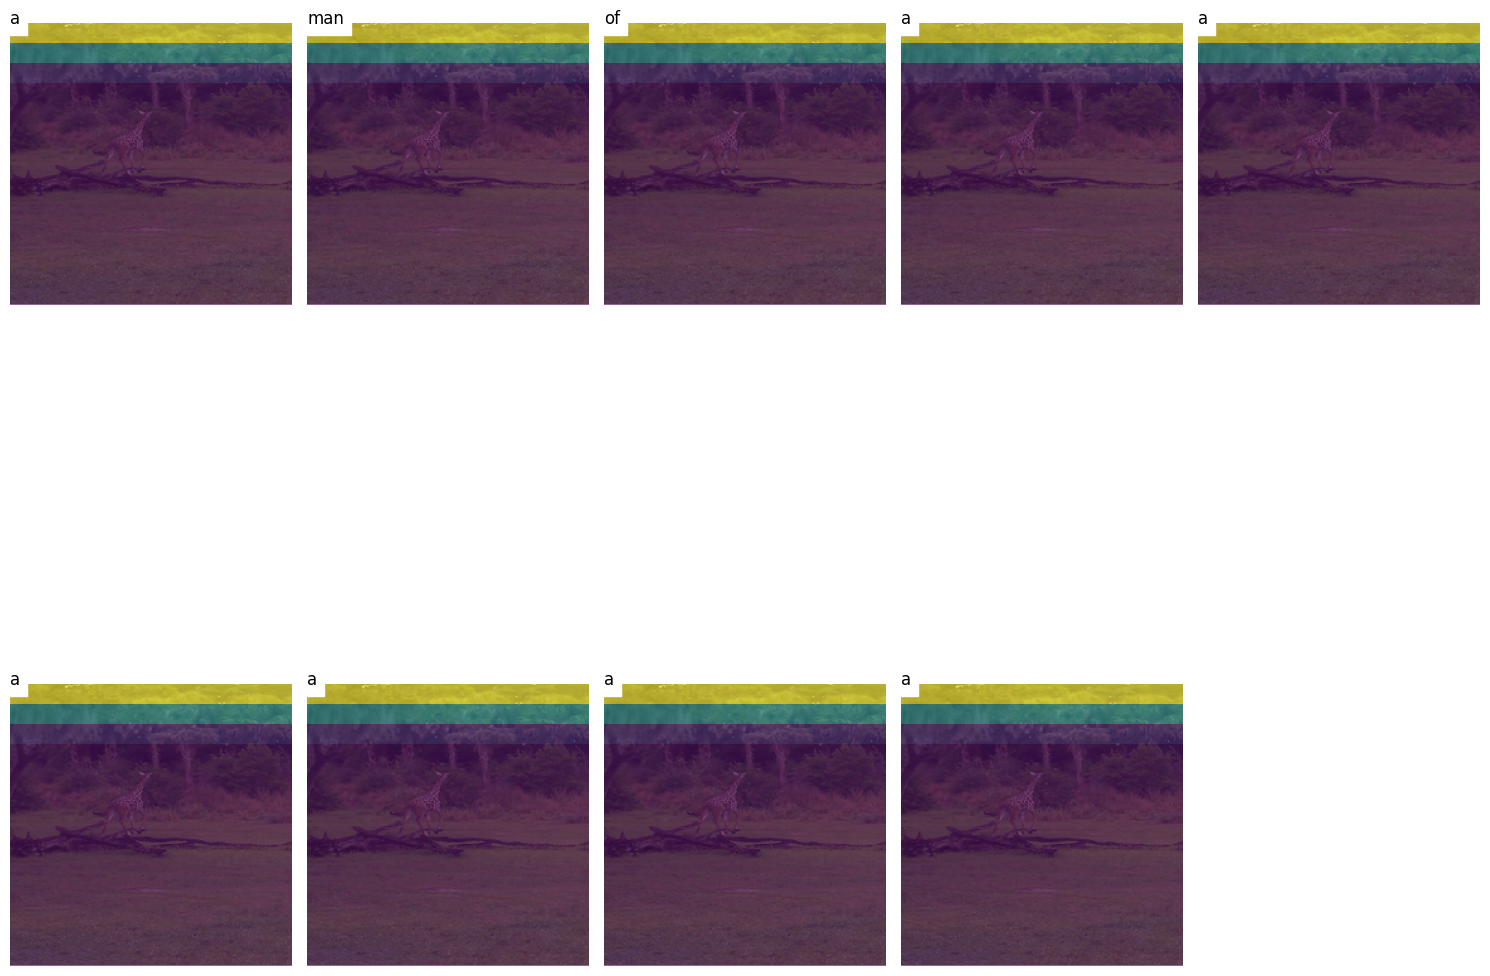

In [ ]:
# Load image
image_path = os.path.join(IMAGE_FOLDER2, f"{int(selected_val_image_ids[0]):012}.jpg")
image = Image.open(image_path).convert("RGB")

# Transform image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Encode image
encoder_out = encoder(image_tensor)
caption, alphas = generate_caption_with_attention(decoder, encoder_out, word_map)

# Visualize
visualize_attention(image_path, caption, alphas)